進階的 RAG 技巧，包括

1. Query Expansion 
2. HyDE
2. Re-ranking
4. small-to-big 策略


## 1. Query Expansion
Query Expansion 是擴展原始查詢以包括更多相關術語的過程。這有助於提高檢索結果的覆蓋範圍和準確性。在示例中，我們將原始查詢 "machine learning" 擴展為 "machine learning AI data science neural networks"。

## 2. HyDE (Hypothetical Document Embeddings)
HyDE 技術生成基於查詢的假設文檔嵌入，這些嵌入可以用於更好的文檔檢索。在示例中，我們使用文本生成模型來生成假設文檔，並將其嵌入表示為隨機向量（應替換為實際嵌入生成方法）。

## 3. Re-ranking
Re-ranking 是根據查詢嵌入和文檔嵌入之間的相似性對文檔進行重新排序的過程。這有助於確保最相關的文檔在檢索結果中排在前面。在示例中，我們使用餘弦相似度來計算相似性並對文檔進行排序。

## 4. Small-to-Big Strategy
Small-to-Big 策略是一種逐步細化查詢並檢索文檔的方法。通過多次擴展查詢和重新排序文檔，可以逐步收斂到最相關的文檔集。在示例中，我們從初始查詢開始，逐步擴展查詢並檢索文檔，最終獲得一組最相關的文檔。

## 1. 向量資料庫準備

In [6]:
# Import necessary libraries
## 設定 OpenAI API Key 變數
from dotenv import load_dotenv
import os

# Load the environment variables from .env file
load_dotenv()

# Access the API key
openai_api_key = os.getenv('OPENAI_API_KEY')



In [7]:
!pip install chromadb
!pip install langchain


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import requests
import json
from pprint import pp

In [9]:
def get_completion(messages, model="gpt-3.5-turbo", temperature=0, max_tokens=1000, format_type=None):
  payload = { "model": model, "temperature": temperature, "messages": messages, "max_tokens": max_tokens }
  if format_type:
    payload["response_format"] =  { "type": format_type }

  headers = { "Authorization": f'Bearer {openai_api_key}', "Content-Type": "application/json" }
  response = requests.post('https://api.openai.com/v1/chat/completions', headers = headers, data = json.dumps(payload) )
  obj = json.loads(response.text)
  if response.status_code == 200 :
    return obj["choices"][0]["message"]["content"]
  else :
    return obj["error"]

In [10]:
def get_embeddings(input, dimensions = 1536, model="text-embedding-3-small"):
  payload = { "input": input, "model": model, "dimensions": dimensions }
  headers = { "Authorization": f'Bearer {openai_api_key}', "Content-Type": "application/json" }
  response = requests.post('https://api.openai.com/v1/embeddings', headers = headers, data = json.dumps(payload) )
  obj = json.loads(response.text)
  if response.status_code == 200 :
    return obj["data"][0]["embedding"]
  else :
    return obj["error"]

In [11]:
!pip install pypdf -q


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


測試資料準備
財經週報 PDF 文件:

* https://www.megabank.com.tw/personal/investment/bulletin/weekly-journal?searchyear=&searchmon=10

In [12]:
import os
import requests

pdf_urls = [
    ["2024/2/26","https://www.megabank.com.tw/-/media/mega/files/bank/personal/fund/bulletin/weekly-journal/market-analysis/113/1130226.pdf"],
    ["2024/2/19", "https://www.megabank.com.tw/-/media/mega/files/bank/personal/fund/bulletin/weekly-journal/market-analysis/113/1130219.pdf"],
    ["2024/2/15", "https://www.megabank.com.tw/-/media/mega/files/bank/personal/fund/bulletin/weekly-journal/market-analysis/113/1130215.pdf"],
    ["2024/2/5", "https://www.megabank.com.tw/-/media/mega/files/bank/personal/fund/bulletin/weekly-journal/market-analysis/113/1130205.pdf"]
]

download_directory = 'pdfs_data'
os.makedirs(download_directory, exist_ok=True)  # 確保目標目錄存在

for pdf_url in pdf_urls:
    response = requests.get(pdf_url[1])
    if response.status_code == 200:
        target_path = os.path.join(download_directory, os.path.basename(pdf_url[1]))
        with open(target_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded: {target_path}")
    else:
        print(f"Failed to download {pdf_url[1]}, status code: {response.status_code}")


Downloaded: pdfs_data\1130226.pdf
Downloaded: pdfs_data\1130219.pdf
Downloaded: pdfs_data\1130215.pdf
Downloaded: pdfs_data\1130205.pdf


## 建 vector data

In [13]:
import chromadb
chroma_client = chromadb.Client()

collection = chroma_client.create_collection(name="collection")

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)


# doc1 -> 0: 500
# doc2 -> 400: 900
# .
# .

In [15]:
# pip install -U langchain-community

In [16]:
# 獲取當前工作目錄
current_directory = os.getcwd()

# 定義 PDF 文件的目標目錄
pdfs_directory = os.path.join(current_directory, "pdfs_data")

pdfs_directory

'd:\\python_workspace\\github\\iSpan_LLM-NLP-cookbooks\\Langchain_scratch\\prompt-engineering\\pdfs_data'

In [17]:
import re
from langchain.document_loaders import PyPDFLoader

for i, pdf_url in enumerate(pdf_urls):
  file_pattern = r"([^/]+\.pdf)"
  file_match = re.search(file_pattern, pdf_url[1])
  pdf_filename = file_match.group(0) if file_match else None
  pdf_file_path = os.path.join(pdfs_directory, pdf_filename)
  print(pdf_file_path)

  loader = PyPDFLoader(pdf_file_path)
  text_docs = loader.load()

  for page in text_docs:
    chunks = text_splitter.split_text(page.page_content)
    for j, chunk in enumerate(chunks):
      collection.add(
        documents = chunk,
        embeddings = get_embeddings(chunk),
        metadatas = { "file": pdf_filename, "page": page.metadata['page'], "date": pdf_url[0] },
        ids = f"doc-{i}-page-{page.metadata['page']}-chunk-{j}"
      )


d:\python_workspace\github\iSpan_LLM-NLP-cookbooks\Langchain_scratch\prompt-engineering\pdfs_data\1130226.pdf


c:\Users\xdxd2\AppData\Local\Programs\Python\Python311\Lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


d:\python_workspace\github\iSpan_LLM-NLP-cookbooks\Langchain_scratch\prompt-engineering\pdfs_data\1130219.pdf
d:\python_workspace\github\iSpan_LLM-NLP-cookbooks\Langchain_scratch\prompt-engineering\pdfs_data\1130215.pdf
d:\python_workspace\github\iSpan_LLM-NLP-cookbooks\Langchain_scratch\prompt-engineering\pdfs_data\1130205.pdf


## 2. Query expansion 和 HyDE

調整搜尋向量資料庫的 Query，產生多種變形，搜出更多相似結果

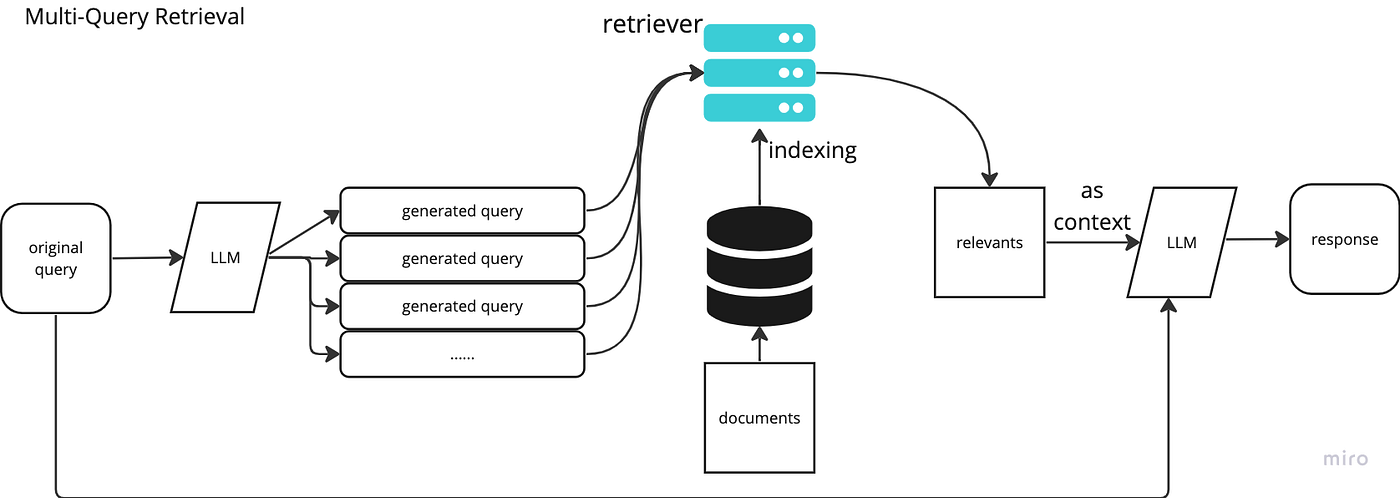

In [18]:
# 方法一: 根據用戶問題，產生多種不同變形的 query
# 或是拆解成子問題也不錯，例如
#   You are a helpful assistant that expands a user query into sub-queries. The sub-queries should be mutually exclusive and collectively exhaustive.
def generate_expansion_queries(original_query):
  messages=[
      {"role": "system", "content": "You are a helpful assistant that generates multiple search queries based on a single input query."},
      {"role": "user", "content": f"Generate multiple search queries related to: {original_query}"},
      {"role": "user", "content": "OUTPUT(3 queries):"}
  ]
  result = get_completion(messages)
  return result.strip().split("\n")

# 方法二: 根據用戶問題，產生假設性的回答 (這招叫做 HyDE 法)
def generate_hyde(original_query):
  messages=[
      {"role": "system", "content": "Please write a short hypothetical answer for the question:"},
      {"role": "user", "content": original_query }
  ]
  result = get_completion(messages)
  return result

In [19]:
question = "美國的經濟"


In [20]:
generated_queries = generate_expansion_queries(question)
generated_queries

['1. 美國的經濟增長情況', '2. 美國的經濟政策', '3. 美國的經濟發展趨勢']

In [21]:
generated_answer = generate_hyde(question)
generated_queries.append(generated_answer)


In [22]:
generated_answer

'美國的經濟一直以來都是全球最強大和最具影響力的之一。其經濟體系是一個混合經濟體系，結合了市場經濟和政府干預。美國擁有多元化的經濟結構，包括製造業、金融業、科技業等多個領域。此外，美國也是全球最大的消費市場之一，消費者信心和支出對經濟增長至關重要。總的來說，美國的經濟實力使其在國際舞台上扮演著重要的角色。'

In [23]:
generated_queries

['1. 美國的經濟增長情況',
 '2. 美國的經濟政策',
 '3. 美國的經濟發展趨勢',
 '美國的經濟一直以來都是全球最強大和最具影響力的之一。其經濟體系是一個混合經濟體系，結合了市場經濟和政府干預。美國擁有多元化的經濟結構，包括製造業、金融業、科技業等多個領域。此外，美國也是全球最大的消費市場之一，消費者信心和支出對經濟增長至關重要。總的來說，美國的經濟實力使其在國際舞台上扮演著重要的角色。']

In [24]:
query_embeddings = [ get_embeddings(query) for query in generated_queries]

In [25]:
results = collection.query(
    query_embeddings = query_embeddings, # 這可以傳 array
    n_results=3
)

In [26]:
results

{'ids': [['doc-3-page-10-chunk-0',
   'doc-2-page-3-chunk-1',
   'doc-2-page-7-chunk-0'],
  ['doc-3-page-9-chunk-1', 'doc-2-page-6-chunk-1', 'doc-0-page-6-chunk-1'],
  ['doc-0-page-6-chunk-1', 'doc-3-page-10-chunk-1', 'doc-0-page-6-chunk-0'],
  ['doc-3-page-10-chunk-0', 'doc-2-page-7-chunk-0', 'doc-0-page-6-chunk-0']],
 'distances': [[0.8425810933113098, 0.8453899621963501, 0.8501354455947876],
  [0.9477681517601013, 0.9909405708312988, 1.0115582942962646],
  [0.9110623598098755, 0.9171887040138245, 0.9260700941085815],
  [1.011621356010437, 1.026902198791504, 1.0414217710494995]],
 'metadatas': [[{'date': '2024/2/5', 'file': '1130205.pdf', 'page': 10},
   {'date': '2024/2/15', 'file': '1130215.pdf', 'page': 3},
   {'date': '2024/2/15', 'file': '1130215.pdf', 'page': 7}],
  [{'date': '2024/2/5', 'file': '1130205.pdf', 'page': 9},
   {'date': '2024/2/15', 'file': '1130215.pdf', 'page': 6},
   {'date': '2024/2/26', 'file': '1130226.pdf', 'page': 6}],
  [{'date': '2024/2/26', 'file': '113

In [27]:
len(results["documents"])

4

我們會得到 5 個搜尋結果列表，每個列表有 3 筆結果。

In [28]:
generated_queries

['1. 美國的經濟增長情況',
 '2. 美國的經濟政策',
 '3. 美國的經濟發展趨勢',
 '美國的經濟一直以來都是全球最強大和最具影響力的之一。其經濟體系是一個混合經濟體系，結合了市場經濟和政府干預。美國擁有多元化的經濟結構，包括製造業、金融業、科技業等多個領域。此外，美國也是全球最大的消費市場之一，消費者信心和支出對經濟增長至關重要。總的來說，美國的經濟實力使其在國際舞台上扮演著重要的角色。']

In [29]:
results["documents"]

[['本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出\n買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。美國就業數據強勁 支撐消費信心\n資料來源 :Blooberg,2024.2.2\n11本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出\n買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。•製造業回溫： 1月ISM製造業指數升至 49.1，創15個月新高 ，不過供應延遲導致工廠成本上升 ，增添通膨升溫擔憂 。\n•消費信心升至 3年高點： 民眾對經濟和就業市場更加樂觀 ，1月經濟諮商局消費者信心指數自去年 12月修正後的 108.0升至\n114.8，為2021年底以來新高 ，1月密大消費者信心指數終值升至 79，創2005年以來最大單月增幅 。\n•勞動市場強勁： 去年12月JOLTS職位空缺數報 902.6萬個，遠高於市場預期 。1月ADP就業人數 10.7萬人，雖創2023年11',
  '中國 人民幣新增貸款 Jan 4,515.16 b 4,920.00b 1,170.9b\n中國 社會融資 (人民幣 ) Jan 5,721.63 b 6,500.00b 1,940.1b\n台灣 出口 (年比 ) Jan 17.30% 18.10% 11.80%\n美國 CPI(年比 ) Jan 2.90% 3.10% 3.40%\n美國 核心 CPI(年比 ) Jan 3.75% 3.90% 3.90%\n歐元區 GDP年增率 2023 Q4 終值 0.10% 0.10% 0.10%\n本週經濟數據\n日期 國家 項目 資料期間 市場預期 前值\n2/15 日本 GDP年增率 2023 Q4 1.40% -2.90%\n2/15 美國 零售銷售 (月比 ) Jan 0.20% 0.60%\n2/15 美國 工業生產 (月比 ) Jan 0.40% 0.10%\n2/16 美國 PPI(年比 ) Jan -- 1.00%\n2/16 美國 核心 PPI(年比 ) Jan -- 1.80%\n2/16 美國 密大消費者信心指數 Feb -- 79.00',
  '本資料純屬參考性質，兆豐商銀不作任何保證與

In [30]:
import re
from langchain.document_loaders import PyPDFLoader

for i, pdf_url in enumerate(pdf_urls):
  file_pattern = r"([^/]+\.pdf)"
  file_match = re.search(file_pattern, pdf_url[1])
  pdf_filename = file_match.group(0) if file_match else None
  pdf_file_path = os.path.join(pdfs_directory, pdf_filename)
  print(pdf_file_path)

  loader = PyPDFLoader(pdf_file_path)
  text_docs = loader.load()


  for page in text_docs:
    print(page.metadata["page"])
    # chunks = text_splitter.split_text(page.page_content)
    for j, chunk in enumerate(chunks):
      # 'doc-0-page-3-chunk-1
      if i == 0 and page.metadata["page"] == 3 and j == 1:
          print(chunk)
 
      else:
        continue

        

d:\python_workspace\github\iSpan_LLM-NLP-cookbooks\Langchain_scratch\prompt-engineering\pdfs_data\1130226.pdf
0
1
2
3
5. 本資料所載內容取⾃本公司相信可靠之資料來源 ，且為特定日期之判斷 ，本公司不保證其即時性 、精確性及完整性 ，亦不提供或嘗試遊說客戶做為投資之判斷依據 。
資料內容邇後若有變更 ，本公司將不做預告或主動更新 。投資人於決策時應審慎衡量本身風險 ，如因信賴本資料內容而做出或改變投資決策 ，須⾃行承擔結果 ，本
公司及本公司所屬員工 ，均不負任何損害賠償及其他法律上之責任 。
6. 本資料內容之著作權屬兆豐銀行所有 ，禁止就所載資料任何形式之抄襲 、引用或轉載 。
7. 本資料所載部分基金涉及非投資等級債 ，投資人投資以非投資等級債券為訴求之基金不宜占其投資組合過高之比重 。基金經金管會核准 ，惟不表示絕無風險 。由於
非投資等級債券之信用評等未達投資等級或未經信用評等 ，且對利率變動的敏感度甚高 ，故本基金可能會因利率上升 、市場流動性下降 ，或債券發行機構違約不支
付本金 、利息或破產而蒙受虧損 。部分基金不適合無法承擔相關風險之投資人 。基金經理公司以往之經理績效不保證基金之最低投資收益；基金經理公司除盡善良
4
5
6
7
8
9
10
11
12
13
14
15
d:\python_workspace\github\iSpan_LLM-NLP-cookbooks\Langchain_scratch\prompt-engineering\pdfs_data\1130219.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
d:\python_workspace\github\iSpan_LLM-NLP-cookbooks\Langchain_scratch\prompt-engineering\pdfs_data\1130215.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
d:\python_workspace\github\iSpan_LLM-NLP-cookbooks\Langchain_scratch\prompt-engineering\pdfs_dat

In [31]:
for QA in zip(generated_queries, results["documents"]):
    print(f"###############問題 {QA[0]}")
    print(f"答案: {QA[1][0]}")
    print("-------")

    

###############問題 1. 美國的經濟增長情況
答案: 本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出
買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。美國就業數據強勁 支撐消費信心
資料來源 :Blooberg,2024.2.2
11本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出
買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。•製造業回溫： 1月ISM製造業指數升至 49.1，創15個月新高 ，不過供應延遲導致工廠成本上升 ，增添通膨升溫擔憂 。
•消費信心升至 3年高點： 民眾對經濟和就業市場更加樂觀 ，1月經濟諮商局消費者信心指數自去年 12月修正後的 108.0升至
114.8，為2021年底以來新高 ，1月密大消費者信心指數終值升至 79，創2005年以來最大單月增幅 。
•勞動市場強勁： 去年12月JOLTS職位空缺數報 902.6萬個，遠高於市場預期 。1月ADP就業人數 10.7萬人，雖創2023年11
-------
###############問題 2. 美國的經濟政策
答案: •利率前瞻指引刪除「任何額外緊縮政策」措辭， 排除進
一步升息的可能性 ；在對通膨持續朝 2%目標邁進更有
信心前，不適合降息。
主席鮑爾談話
•聯準會可能已經完成本輪升息週期。
•還沒有準備好宣告經濟已實現軟著陸， 3 月降息並非基
本情境 。
•3月將深入討論縮表速度及資產負債表。■存款機構準備金 (右) ■附賣回協議 (右) ■財政部帳戶 (左)■聯準會資產負債表 -7.66 兆美元
%
-------
###############問題 3. 美國的經濟發展趨勢
答案: 新低，顯示就業市場持續強勁 。(3)經濟諮商局 1月份領先經濟指標報 102.7，較上月下降 0.4%，但不再預估景氣將衰退 。
•展望:2月美銀美林經理人報告 ，淨加碼美股及科技股 ，且做多驚奇 7股票列最擁擠交易首位 。短線美股因市場調整降息預
期、科技股累積不小漲幅而有所震盪 ，受惠基本面強勁及 AI題材助攻 ，美股可望維持多頭格局 ，逢回仍可分批佈局 。市
場
回
顧
市
場
焦
點
聚
焦
議
題美國

In [32]:
all_chunks = [item for sublist in results["documents"] for item in sublist]

len(all_chunks)

12

## 3. Re-ranking

我們有了多個搜尋結果列表，需要合併起來排序，然後只取前幾筆最相關的，不然 context window 塞不下。

這裡我們使用 https://huggingface.co/BAAI/bge-reranker-base 這個開源的 Reranker model

In [33]:
!pip install sentence_transformers


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


CrossEncoder 是一種基於 Transformer 的模型，用於比較和評分兩個句子的相關性。它將兩個句子拼接後通過共享的 Transformer 編碼器生成一個評分，表示句子之間的相似度。由於對句子對進行整體編碼，CrossEncoder 能捕捉更多的上下文信息，因此在一些任務中比 Bi-Encoder 更精確。

主要特點：

整體編碼：對兩個句子整體編碼，捕捉上下文關係。
高精度：提供比 Bi-Encoder 更高的準確度。
資源需求：需要較高計算資源。
應用場景：

資訊檢索
問答系統
文本匹配

In [34]:
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder('BAAI/bge-reranker-base') # base 要 1.1G，large 要 2.24G

c:\Users\xdxd2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\xdxd2\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [35]:
pairs = [[question, doc] for doc in all_chunks]
scores = cross_encoder.predict(pairs)
print("相關性分數: ")
for score in scores:
    print(score)

相關性分數: 
0.30887714
0.058532283
0.84121907
0.09172355
0.3793249
0.631784
0.631784
0.15371348
0.86371
0.30887714
0.84121907
0.86371


In [36]:
import numpy as np

In [37]:
ordered_index = np.argsort(scores)[::-1]
ordered_index

array([11,  8, 10,  2,  6,  5,  4,  9,  0,  7,  3,  1], dtype=int64)

In [38]:
all_chunks

['本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出\n買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。美國就業數據強勁 支撐消費信心\n資料來源 :Blooberg,2024.2.2\n11本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出\n買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。•製造業回溫： 1月ISM製造業指數升至 49.1，創15個月新高 ，不過供應延遲導致工廠成本上升 ，增添通膨升溫擔憂 。\n•消費信心升至 3年高點： 民眾對經濟和就業市場更加樂觀 ，1月經濟諮商局消費者信心指數自去年 12月修正後的 108.0升至\n114.8，為2021年底以來新高 ，1月密大消費者信心指數終值升至 79，創2005年以來最大單月增幅 。\n•勞動市場強勁： 去年12月JOLTS職位空缺數報 902.6萬個，遠高於市場預期 。1月ADP就業人數 10.7萬人，雖創2023年11',
 '中國 人民幣新增貸款 Jan 4,515.16 b 4,920.00b 1,170.9b\n中國 社會融資 (人民幣 ) Jan 5,721.63 b 6,500.00b 1,940.1b\n台灣 出口 (年比 ) Jan 17.30% 18.10% 11.80%\n美國 CPI(年比 ) Jan 2.90% 3.10% 3.40%\n美國 核心 CPI(年比 ) Jan 3.75% 3.90% 3.90%\n歐元區 GDP年增率 2023 Q4 終值 0.10% 0.10% 0.10%\n本週經濟數據\n日期 國家 項目 資料期間 市場預期 前值\n2/15 日本 GDP年增率 2023 Q4 1.40% -2.90%\n2/15 美國 零售銷售 (月比 ) Jan 0.20% 0.60%\n2/15 美國 工業生產 (月比 ) Jan 0.40% 0.10%\n2/16 美國 PPI(年比 ) Jan -- 1.00%\n2/16 美國 核心 PPI(年比 ) Jan -- 1.80%\n2/16 美國 密大消費者信心指數 Feb -- 79.00',
 '本資料純屬參考性質，兆豐商銀不作任何保證與承諾。

In [39]:
context = ''

# 取前三名
for i in ordered_index[:3]:
  print(all_chunks[i])
  context = context + f"{all_chunks[i]} \n------\n"

本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出
買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。美國經濟穩固 科技股領美股創新高
7本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出
買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。•上週表現 :Nvidia財報及財測均優於預期 ，加上經濟數據強勁 ，科技股領美股再創歷史新高 。
•經濟數據 :(1)標普全球 2月美國製造業採購經理人 (PMI)初值報 51.5，創17個月以來新高；但服務業 PMI初值報 51.3，創3
個月新低 ，致綜合 PMI初值降至 51.4，低於預期 ，整體景氣維持擴張態勢 。(2)上週初領失業金人數降至 20.1萬，創1個月
新低，顯示就業市場持續強勁 。(3)經濟諮商局 1月份領先經濟指標報 102.7，較上月下降 0.4%，但不再預估景氣將衰退 。
本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出
買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。美國經濟穩固 科技股領美股創新高
7本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出
買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。•上週表現 :Nvidia財報及財測均優於預期 ，加上經濟數據強勁 ，科技股領美股再創歷史新高 。
•經濟數據 :(1)標普全球 2月美國製造業採購經理人 (PMI)初值報 51.5，創17個月以來新高；但服務業 PMI初值報 51.3，創3
個月新低 ，致綜合 PMI初值降至 51.4，低於預期 ，整體景氣維持擴張態勢 。(2)上週初領失業金人數降至 20.1萬，創1個月
新低，顯示就業市場持續強勁 。(3)經濟諮商局 1月份領先經濟指標報 102.7，較上月下降 0.4%，但不再預估景氣將衰退 。
本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出
買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。美

In [40]:
# https://docs.anthropic.com/claude/docs/advanced-text-analysis
prompt=  f"""
I'm going to give you a document. Then I'm going to ask you a question about it. I'd like you to first write down exact quotes of parts of the document that would help answer the question, and then I'd like you to answer the question using facts from the quoted content. Here is the document:

<document>
{context}
</document>

Here is the first question:  {question}

First, find the quotes from the document that are most relevant to answering the question, and then print them in numbered order. Quotes should be relatively short.

If there are no relevant quotes, write "No relevant quotes" instead.

Then, answer the question, starting with "Answer:".  Do not include or reference quoted content verbatim in the answer. Don't say "According to Quote [1]" when answering. Instead make references to quotes relevant to each section of the answer solely by adding their bracketed numbers at the end of relevant sentences.

Thus, the format of your overall response should look like what's shown between the <example></example> tags.  Make sure to follow the formatting and spacing exactly.

<example>

Relevant quotes:
[1] "Company X reported revenue of $12 million in 2021."
[2] "Almost 90% of revenue came from widget sales, with gadget sales making up the remaining 10%."

Answer:
Company X earned $12 million. [1]  Almost 90% of it was from widget sales. [2]

</example>

If the question cannot be answered by the document, say so.

Answer the question immediately without preamble.
請用台灣繁體中文回答.
"""


result = get_completion([ {"role": "user", "content": prompt }], model="gpt-4-turbo-preview")
print(result)

Relevant quotes:
[1] "美國經濟穩固 科技股領美股創新高"
[2] "標普全球 2月美國製造業採購經理人 (PMI)初值報 51.5，創17個月以來新高"
[3] "服務業 PMI初值報 51.3，創3個月新低"
[4] "綜合 PMI初值降至 51.4，低於預期 ，整體景氣維持擴張態勢"
[5] "上週初領失業金人數降至 20.1萬，創1個月新低，顯示就業市場持續強勁"
[6] "經濟諮商局 1月份領先經濟指標報 102.7，較上月下降 0.4%，但不再預估景氣將衰退"
[7] "服務業景氣持續擴張"
[8] "民眾對經濟和就業市場樂觀 ，消費信心強勁"

Answer:
美國經濟整體表現穩固，科技股的表現帶動美股創下新高[1]。製造業和服務業的採購經理人指數(PMI)顯示，儘管服務業PMI略有下降，整體經濟仍維持擴張態勢[2][3][4]。此外，失業金申請人數降至新低，顯示就業市場的強勁[5]。經濟諮商局的領先經濟指標也顯示，經濟不再預估將會衰退[6]。服務業的景氣持續擴張[7]，且民眾對經濟和就業市場保持樂觀，消費信心強勁[8]。


## 4. small-to-big 策略

用來做索引的 chunk embeddings，和用來生成用的 context 內容，不需要一模一樣

在本案例中，我們可以在 LLM 生成時，改成採用該 chunk 所在頁面的整頁內容，當作 context

好處: 在生成階段，有更完整的上下文 context

這個思路在 langchain 和 llamaindex 有很多種變形，例如:

* langchain 的 https://python.langchain.com/docs/modules/data_connection/retrievers/parent_document_retriever
* llamaindex 的 sentence window, auto merging retriever 等

都是在 LLM 生成階段，延伸組成更長的上下文

In [41]:
all_metadatas = [item for sublist in results["metadatas"] for item in sublist]

In [42]:
all_metadatas

[{'date': '2024/2/5', 'file': '1130205.pdf', 'page': 10},
 {'date': '2024/2/15', 'file': '1130215.pdf', 'page': 3},
 {'date': '2024/2/15', 'file': '1130215.pdf', 'page': 7},
 {'date': '2024/2/5', 'file': '1130205.pdf', 'page': 9},
 {'date': '2024/2/15', 'file': '1130215.pdf', 'page': 6},
 {'date': '2024/2/26', 'file': '1130226.pdf', 'page': 6},
 {'date': '2024/2/26', 'file': '1130226.pdf', 'page': 6},
 {'date': '2024/2/5', 'file': '1130205.pdf', 'page': 10},
 {'date': '2024/2/26', 'file': '1130226.pdf', 'page': 6},
 {'date': '2024/2/5', 'file': '1130205.pdf', 'page': 10},
 {'date': '2024/2/15', 'file': '1130215.pdf', 'page': 7},
 {'date': '2024/2/26', 'file': '1130226.pdf', 'page': 6}]

In [43]:
ordered_index[:3]

array([11,  8, 10], dtype=int64)

In [44]:

pdfs_directory = os.path.join(pdfs_directory, all_metadatas[i]["file"])

In [45]:
all_context = []

pdfs_directory = os.path.join(current_directory, "pdfs_data")
for i in ordered_index[:3]:
  pdf_path = os.path.join(pdfs_directory, all_metadatas[i]["file"])
  pdf_pages = PyPDFLoader(pdf_path).load()


  
  page_content = pdf_pages[ all_metadatas[i]["page"] ].page_content
  all_context.append(page_content)

context = ''
for page_content in list(set(all_context)):
  context = context + f"{page_content} \n------\n"

In [46]:
print(context)

本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出
買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。美國經濟數據強勁 支撐消費信心
資料來源 :Blooberg,2024.2.6
8本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出
買賣任何內文所涉及之證券建議、誘導及鼓勵相關交易。•服務業景氣持續擴張 ，但紅海衝突引發供應鏈疑慮： 受訂單和就業成長推動 ，1月ISM服務業指數上升至 53.4的四個月高
點，其中新訂單的指數升至 55，創3個月高點 ，就業指標反彈至 50.5重返擴張 ，惟原料支付價格指數升至 64，增幅為
2012年以來最大 ，引發通膨重燃擔憂 。紐約Fed銀行調查顯示 ，1月全球供應鏈壓力指數從前月的 -0.15升至-0.11，反映
當前供應鏈壓力有所上升 ，紅海航運影響尚未完全顯現 。
•民眾對經濟和就業市場樂觀 ，消費信心強勁 。市
場
回
顧
市
場
焦
點
聚
焦
議
題
資
產
觀
點ISM製造業 /非製造業指數 美國消費者信心指數
406080100120140
2021/01
2021/03
2021/05
2021/07
2021/09
2021/11
2022/01
2022/03
2022/05
2022/07
2022/09
2022/11
2023/01
2023/03
2023/05
2023/07
2023/09
2023/11
2024/01
密西根大學消費信心指數 經濟諮商局消費信心指數49.153.4
40455055606570
01/2021
03/2021
05/2021
07/2021
09/2021
11/2021
01/2022
03/2022
05/2022
07/2022
09/2022
11/2022
01/2023
03/2023
05/2023
07/2023
09/2023
11/2023
01/2024
ISM製造業指數 ISM非製造業指數 榮枯線 
------
本資料純屬參考性質，兆豐商銀不作任何保證與承諾。上述資料，任何人因信賴此資料而做出或改變決策，本身須承擔一切風險，報告資料並無做出
買賣任何內文所涉及之證券建議、誘導

In [47]:
# https://docs.anthropic.com/claude/docs/advanced-text-analysis
prompt=  f"""
I'm going to give you a document. Then I'm going to ask you a question about it. I'd like you to first write down exact quotes of parts of the document that would help answer the question, and then I'd like you to answer the question using facts from the quoted content. Here is the document:

<document>
{context}
</document>

Here is the first question:  {question}

First, find the quotes from the document that are most relevant to answering the question, and then print them in numbered order. Quotes should be relatively short.

If there are no relevant quotes, write "No relevant quotes" instead.

Then, answer the question, starting with "Answer:".  Do not include or reference quoted content verbatim in the answer. Don't say "According to Quote [1]" when answering. Instead make references to quotes relevant to each section of the answer solely by adding their bracketed numbers at the end of relevant sentences.

Thus, the format of your overall response should look like what's shown between the <example></example> tags.  Make sure to follow the formatting and spacing exactly.

<example>

Relevant quotes:
[1] "Company X reported revenue of $12 million in 2021."
[2] "Almost 90% of revenue came from widget sales, with gadget sales making up the remaining 10%."

Answer:
Company X earned $12 million. [1]  Almost 90% of it was from widget sales. [2]

</example>

If the question cannot be answered by the document, say so.

Answer the question immediately without preamble.
請用台灣繁體中文回答.
"""

In [48]:
result = get_completion([ {"role": "user", "content": prompt }], model="gpt-4-turbo-preview")
print(result)

Relevant quotes:
[1] "美國經濟數據強勁 支撐消費信心"
[2] "服務業景氣持續擴張"
[3] "民眾對經濟和就業市場樂觀，消費信心強勁。"
[4] "美國經濟穩固 科技股領美股創新高"
[5] "標普全球 2月美國製造業採購經理人 (PMI)初值報 51.5，創17個月以來新高"
[6] "整體景氣維持擴張態勢"
[7] "顯示就業市場持續強勁"

Answer:
美國的經濟表現強勁，支撐了消費者的信心。服務業的景氣持續擴張，且民眾對經濟和就業市場保持樂觀態度。此外，科技股的表現帶領美股達到新高，反映出經濟的穩固。製造業的採購經理人指數顯示，經濟景氣維持在擴張的態勢中，且就業市場亦顯示出持續的強勁。这些因素綜合反映了美國經濟的整體正面發展。
